In [ ]:
#Installing dependencies
!pip install biopython
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 12.1 MB/s eta 0:00:00


Below, we get the papers and abstracts to parse

Enter your email and the search term (e.g., 'cesa arabidopsis')

Define the max number ofg papers to retrieve

This is fairly quick and should be fine for specific searches

In [ ]:
from Bio import Entrez

# Enter your email address for Entrez authentication
Entrez.email = "mutwil@gmail.com"

# Define the search term
search_term = "cesa arabidopsis"

# Define the maximum number of publications to get
retmax = 600

# Search NCBI for the given term, excluding reviews
handle = Entrez.esearch(db="pubmed", term=search_term+" NOT review[pt]", retmax=retmax)
record = Entrez.read(handle)

# Get the list of IDs for the search results
id_list = record["IdList"]

# Fetch the abstracts for the IDs
handle = Entrez.efetch(db="pubmed", id=id_list, rettype="medline", retmode="text")
records = handle.read()

# Split the records by abstract
records = records.split("\n\n")

# Create a text file to write the titles and abstracts to

paper2abs = {}
for record in records:
    
    pmid = None
    date = None
    journal = None
    title = None
    abstract = None
    doi = None
    author = None

    # Split the record by line
    lines = record.split("\n")
    doing_abstract, doing_title = 0,0

    # Extract the full title and abstract from the lines
    for i, line in enumerate(lines):
        #print(line)
        if line!='':
          if line.startswith('PMID- '):
            pmid = line[6:]
          if line.startswith('DP  '):
            date = line[6:]
          if line.startswith('TA'):
            journal = line[6:]
          if line.startswith('LID'):
            doi = line[6:].split()[0]
          if line.startswith('AID'):
            doi = line[6:].split()[0]

          if line.startswith('AU'):
            author = line[6:].split()[0]

          if line.startswith("TI  - "):
                  title = line[6:]
                  doing_title = 1
                  continue
          
          #print("1", line[0], line[0]==' ', doing_title)
          if line[0]==' ' and doing_title==1:
            title += line[6:]
          else:
            doing_title = 0

          if line.startswith("AB  - "):
                  abstract = line[6:]
                  doing_abstract = 1
                  continue
          
          if line[0]==' ' and doing_abstract == 1:
                  abstract += " " + line[6:]
          else:
            doing_abstract = 0            

    # Write the title and abstract to the file
    if title and abstract:
        paper2abs[title] = [pmid, abstract, date, journal, doi, author]

Below, we will use GPT to identify actors (genes) and interactions between them

You need to get an account at https://platform.openai.com/ and get the API keys

Price: 180 abstract costs ~ 3 USD
Runtime: 2 sec / paper 

Define a prompt used by the GPT model to extract functional info

The prompt was tested here: https://platform.openai.com/playground

The prompt is **super important** and you need to tune it iteratively to get it right

But you can ask GPT4 for advice :)

In [40]:
import os
import openai

#Y
#Paste in your openai API key below
openai.api_key = "sk-"

prompt = '''
Write a very short summary about the functions of genes in this abstract. The summary must show pair-wise relationships, for example:
gene A: !affects! process 
process B:  !affects! gene A
process B:  !is affected by! gene A
gene A: !localizes to! B
gene B: !interacts with! B
gene B: !localizes to! A

Please provide only one statement per line, and ensure that each line contains exactly two actors. If a relationship involves more than two actors, please break it down into multiple separate lines.

<ENTER PROMPT HERE>

VERY SHORT, CONCISE SUMMARY: 

'''

paper2response = {}
counter = 0
for paper in paper2abs:
    print('Doing paper %s out of %s' % (counter, len(paper2abs)))
    print('Title': paper)
    print('Abstract:' paper2abs[paper][1])
    my_prompt = prompt.replace('<ENTER PROMPT HERE>',paper2abs[paper][1])

    response = openai.Completion.create(
      model="text-davinci-003",
      prompt=my_prompt,
      temperature=0.7,
      max_tokens=256,
      top_p=1.0,
      frequency_penalty=0.0,
      presence_penalty=1
    )
    print(response['choices'][0]['text']+'\n')
    paper2response[paper] = response['choices'][0]['text']

    counter += 1
    try:
      with open("/gdrive/MyDrive/my_dict.json", "w") as f:
        json_string = json.dumps(paper2response)
        f.write(json_string)
    except:
      pass


Point mutations in the catalytic domain disrupt cellulose synthase (CESA6) vesicle trafficking and protein dynamics.
Cellulose, the main component of the plant cell wall, is synthesized by the  multimeric cellulose synthase (CESA) complex (CSC). In plant cells, CSCs are  assembled in the endoplasmic reticulum or Golgi and transported through the  endomembrane system to the plasma membrane (PM). However, how CESA catalytic  activity or conserved motifs around the catalytic core influence vesicle  trafficking or protein dynamics is not well understood. Here, we used yellow  fluorescent protein (YFP)-tagged AtCESA6 and created 18 mutants in key motifs of  the catalytic domain to analyze how they affected seedling growth, cellulose  biosynthesis, complex formation, and CSC dynamics and trafficking in Arabidopsis  thaliana. Seedling growth and cellulose content were reduced by nearly all  mutations. Moreover, mutations in most conserved motifs slowed CSC movement in  the PM as well as deliv

It's a good idea to save the results to a file and download the file

In [239]:
v = open('paper2response_dict','w') #saved to downloads
v.write(str(paper2response))
v.close()

#download the file from the Files menu on the left
#upload the file again if needed
#uncomment and run if you want to load the file

'''
paper2response = eval(open('paper2response_dict'),'r').readlines()
'''

Let's pars the output from GPT to identify pairs of actors and the interaction types


In [257]:
import matplotlib.pyplot as plt
from collections import Counter
from nltk.stem import WordNetLemmatizer
import collections

lemmatizer = WordNetLemmatizer()
response_types = []
actors = []

#depending on your prompt and the abstract, GPT might return the terms back. We can blacklist the terms here
forbidden = ['GENE A', 'GENE B', 'PROCESS A', 'PROCESS B']

for_converting = []

verbs = []
papernum = 0
edgeDic = {}
for i in paper2response:
  responses = paper2response[i].split('\n')
  for res in responses:
    if res.count('!')==2: 
      if 'GENE A' not in res.upper() or 'GENE B' not in res.upper():
        splitted = res.upper().replace('PROTEINS','').replace('PROTEIN','').replace('GENES','').replace('GENES','').split('!')
        actorA, actorB = splitted[0].replace(':','').strip(), splitted[2].replace(':','').strip()
        lemmatized_word = lemmatizer.lemmatize(splitted[1].lower()).upper()
        verbs.append(lemmatized_word)
        if (actorA in forbidden) + (actorB in forbidden) == 0:
          if len(actorA)>0 and len(actorB)>0:
            response_types.append(lemmatized_word)
            actors.append(actorA)
            actors.append(actorB)
            edge = (actorA, actorB)

            if edge not in edgeDic:
              edgeDic[edge] = {lemmatized_word: [paper2abs[i][0]]}
            else:
              if lemmatized_word not in edgeDic[edge]:
                edgeDic[edge] = {lemmatized_word: [paper2abs[i][0]]}
              else:
                edgeDic[edge][lemmatized_word]+=[paper2abs[i][0]]

Below, let's plot how many actors (genes) and interaction types are found in the searched papers

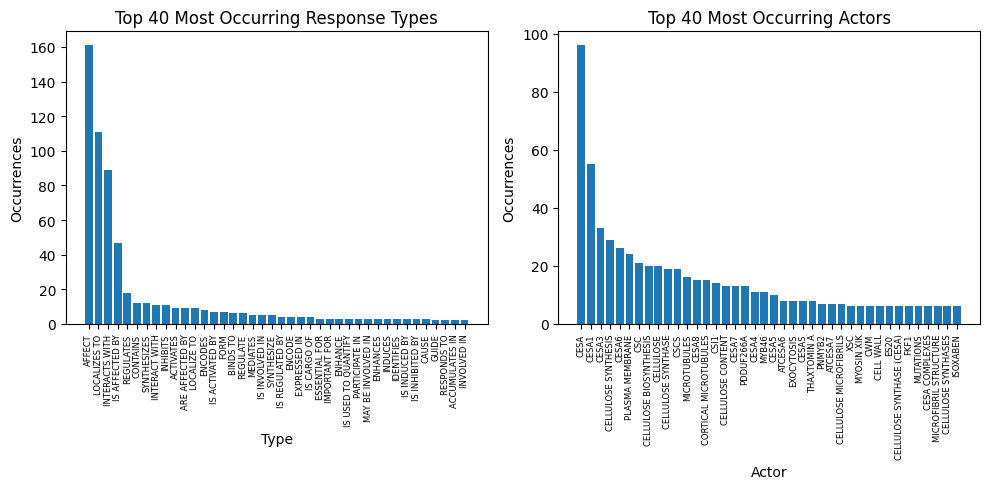

In [261]:
#maximum number of genes and interactions to plot
top_how_many = 40

# Count the occurrence of each string and actor
string_counts = Counter(response_types)
actor_counts = Counter(actors)

# Get the top 20 most occurring strings and actors
top_strings = dict(string_counts.most_common(top_how_many))
top_actors = dict(actor_counts.most_common(top_how_many))

# Create a bar plot with two bars
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.bar(top_strings.keys(), top_strings.values())
ax1.set_xlabel('Type')
ax1.set_ylabel('Occurrences')
ax1.set_title('Top %s Most Occurring Response Types' % top_how_many)

ax2.bar(top_actors.keys(), top_actors.values())
ax2.set_xlabel('Actor')
ax2.set_ylabel('Occurrences')
ax2.set_title('Top %s Most Occurring Actors' % top_how_many)

ax1.set_xticks(range(len(top_strings.keys())))
ax1.set_xticklabels(top_strings.keys(), rotation=90, fontsize=6)

ax2.set_xticks(range(len(top_actors.keys())))
ax2.set_xticklabels(top_actors.keys(), rotation=90, fontsize=6)

plt.tight_layout()
plt.show()

Let's save the network of actors and interactions for cytoscape

Import the files into cytoscape

Good luck

@labmutwil

In [262]:
save_network = ['nodeA\tnodeB\tedge\tedgeCount\n']
#('CESA2', 'STEM ELONGATION') {'AFFECT': ['12068120']}
for edge in edgeDic:
  nodeA, nodeB = edge[0], edge[1]
  types = ''
  paperCount = 0
  for typa in edgeDic[edge]:
    types += typa.replace(' ','_')+' '+str(len(edgeDic[edge]))
    paperCount+=len(edgeDic[edge])

  save_network.append('\t'.join([nodeA, nodeB, types, str(paperCount)])+'\n')

save_nodes = ['node\tcount\n']
for i in actor_counts:
  save_nodes.append(i+'\t'+str(actor_counts[i])+'\n')


v = open('network.txt','w')
v.writelines(save_network)
v.close()

v = open('nodes.txt','w')
v.writelines(save_nodes)
v.close()